# Tarea 1 - Amazon food review

**Integrantes: Fernanda Weiss - Ignacio Espinoza **

En esta tarea se trabajará con el dataset *Amazon Fine Food Review*, el cual contiene más de 500.000 críticas de platos de comida y restaurants provenientes de Amazon. El archivo consiste en un .csv (“Comma Separate Values”) el cual contiene la siguiente estructura:

- **Id** - Id único de cada reseña
- ** ProductId** - Id único que identifica el producto a analizar
- **UserId** - Id único que identifica al usuario
- **ProfileName** - Nombre del usuario que realizó la reseña
- **HelpfulnessNumerator** -  número de usuarios que indicaron que encontraron esta crítica util
- **HelpfulnessDenominator** número de usuarios que indicaron que encontraron esta crítica util -
- **Score** - Rating, con valores entre 1 y 5 estrellas
- **Time** - timestamp for the review
- **Summary** - breve resumen de la reseña
- **Text** - string que contiene la reseña 

Para poder hacer un análisis de las reviews, su contenido y qué información podemos recuperar de ellas, solo nos quedaremos con el atributo Text, consistente en la reseña que hace cada persona sobre comida. El resto de los datos no agrega información relevante para este estudio.

En primer lugar se carga el corpus, quitando todo el código HTML existente con BeautifulSoup, así solo se mantendrá el contenido que exista en dentro de los tag. Las reseñas se almacenan en la lista **corpus**, la cual tiene una estructura de lista de listas *corpus[[documento1],[documento2],...]*. A su vez, se tiene una lista **score** con la evaluación de los usuarios en cada reseña (esta información será utilizada más adelante).

In [1]:
# -*- coding: utf-8 -*-
from bs4 import BeautifulSoup

reviews = open("amazon-fine-foods/Reviews.csv", "r")
corpus = []
score = []

reviews.readline() # sacar header

for line in reviews:
    review = line.strip().split(",")
    text = BeautifulSoup(review[-1], 'html.parser')
    corpus.append([text.get_text()])
    score.append(review[6])

reviews.close()

Una vez cargada la información del corpus se procede a tokenizar cada documento. La tokenización corresponde a romper una secuencia de strings en piezas, en ese caso será en palabras. Mediante expresión regular se quita todo número y signo de puntuación existente, quedando así, solo letras.
Esta información se guarda en la lista **tokens_doc** (lista de listas de tokens). 


En este proceso también se aplica *lower case a las palabras*.

In [2]:
from nltk.tokenize import RegexpTokenizer, regexp_tokenize

tokens_doc = [] #tokens por documento/sentencia

for text in corpus:
    t = regexp_tokenize(text[0].lower(), pattern='[a-zA-Z]+')
    tokens_doc.append(t)
print tokens_doc[:2]

[[u'i', u'have', u'bought', u'several', u'of', u'the', u'vitality', u'canned', u'dog', u'food', u'products', u'and', u'have', u'found', u'them', u'all', u'to', u'be', u'of', u'good', u'quality', u'the', u'product', u'looks', u'more', u'like', u'a', u'stew', u'than', u'a', u'processed', u'meat', u'and', u'it', u'smells', u'better', u'my', u'labrador', u'is', u'finicky', u'and', u'she', u'appreciates', u'this', u'product', u'better', u'than', u'most'], [u'product', u'arrived', u'labeled', u'as', u'jumbo', u'salted', u'peanuts', u'the', u'peanuts', u'were', u'actually', u'small', u'sized', u'unsalted', u'not', u'sure', u'if', u'this', u'was', u'an', u'error', u'or', u'if', u'the', u'vendor', u'intended', u'to', u'represent', u'the', u'product', u'as', u'jumbo']]


Una vez que tenemos los tokens para cada documento, se carga la lista de stopwords desde la librería de nltk. Las stopwords son aquellas palabras que no son descriptivas para el corpus.
Una vez que se realizó el filtrado de las stopwords de nltk se vió que aún existian palabras que no permitían un buen analisis, que no entregaban información relevante, por lo que se creo un archivo con aquellas stopwords que nosotros observamos, *'stopwrds.txt*. Este archivo lo juntamos con las anteriores y se procede a filtrar las palabras de cada documento. Los criterio para que no sean eliminados son:

* No estar en la stoplist
* Largo mayor o igual a 3
* Frecuencia de la palabra en el corpus completo sea mayor o igual a 4

Los tokens son guardados en la lista **tokens**, lista de lista de tokens. En base a esta lista, se crea otra lista, llamada **all_tokens** la cual contiene todos los tokens del corpus, sin separación entre documentosla cual nos permite generar la distribución de las palabras en el corpus según su frecuencia, y así poder utilizar esto como criterio de filtrado.

Se escogió eliminar palabras con frecuencia menor a 4 porque en su mayoría eran palabras sin sentido, palabras mal escritas, palabras en otros idiomas (como chino), entre otros.
             

In [3]:
import nltk
from nltk.corpus import stopwords

# making stoplist with custom stopwords and library stopwords
stoplist = []
f = open("stopwords.txt","r")
for sw in f:
    stoplist.append(sw.strip())
f.close()
stoplist += stopwords.words('english') # stopwords


all_tokens = [token for doc in tokens_doc for token in doc]

frec_dist = nltk.FreqDist(all_tokens) # frec distribution of tokens

# create list of list without stopwords
tokens = []
for doc in tokens_doc: 
    t = []
    
    for token in doc:
        if token not in stoplist and len(token) >= 3 and frec_dist[token] >= 4:
            t.append(token)
    tokens.append(t)
            
print tokens[:2]

[[u'bought', u'several', u'vitality', u'canned', u'dog', u'food', u'products', u'found', u'good', u'quality', u'product', u'looks', u'like', u'stew', u'processed', u'meat', u'smells', u'better', u'labrador', u'finicky', u'appreciates', u'product', u'better'], [u'product', u'arrived', u'labeled', u'jumbo', u'salted', u'peanuts', u'peanuts', u'actually', u'small', u'sized', u'unsalted', u'sure', u'error', u'vendor', u'intended', u'represent', u'product', u'jumbo']]


# Collocations

Se vuelve a generar la lista **all_tokens**, ya que en el paso anterior se eliminaron algunas palabras, por lo que se debe actualizar.
El objetivo de este paso es generar el top-30 collocations, formadas por bigramas. Las collocations son aquellas  palabras que generalmente van juntas dentro de un texto, la cantidad de estas palabras se define según el n-grama usado, este caso es de a dos palabras, por lo tanto se deben buscar los 30 pares de palabras que generalmente van juntas dentro de las reviews de comida de amazon.
Para lograr este objetivo se ejecutan 4 métricas de proximidad entre las palabras:

* likelihood_ratio: Utiliza los ratios de verosimilitud en los bigramas.
* raw_freq: Usa la frecuencia, y considera todos los bigramas en el texto como candidatos de collocations.
* pmi: Usa Pointwise Mutual Information.
* chi_sq: Determina los bigramas utilizando la distribución chi-cuadrado.

Comparando estos resultados, se observa que *likelihood_ratio* entrega un mejor resultado. Luego, le sigue *raw_freq* y *pmi*. Finalmente, la que entrega peores resultados es la *chi_sq*.

En general los resultados de *likelihood_ratio* y *raw_freq* son casi iguales, cambiando el orden de algunos bigramas en la lista de top 30. Se pueden distinguir claramente combinaciones de palabras que uno esperaría encontrar en un dataset que habla sobre comida, como por ejemplo, gluten free, peanut butter, grocery store. Otros más obvios como Amazon com, especialmente porque la información proviene de Amazon.com. 

Por otro lado, *pmi* y *chi_sq* entregan resultados de muy mala calidad. En general son palabras sin sentido y que como bigramas no significan nada.


In [4]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

all_tokens = [token for doc in tokens for token in doc]

finder = BigramCollocationFinder.from_words(all_tokens)
#print finder.items()[0:5]

top_collocations = finder.nbest(bigram_measures.likelihood_ratio, 30) #top 30 bigramas
print top_collocations[:30], "\n"

scored = finder.score_ngrams(bigram_measures.raw_freq)
print scored[:30], "\n"

scored = finder.score_ngrams(bigram_measures.pmi)
print scored[:30], "\n"

scored = finder.score_ngrams(bigram_measures.chi_sq)
print scored[:30], "\n"

[(u'highly', u'recommend'), (u'gluten', u'free'), (u'peanut', u'butter'), (u'subscribe', u'save'), (u'grocery', u'store'), (u'highly', u'recommended'), (u'much', u'better'), (u'would', u'recommend'), (u'year', u'old'), (u'amazon', u'com'), (u'green', u'mountain'), (u'green', u'tea'), (u'cup', u'coffee'), (u'hard', u'find'), (u'waste', u'money'), (u'free', u'shipping'), (u'dog', u'food'), (u'expiration', u'date'), (u'earl', u'grey'), (u'recommend', u'anyone'), (u'long', u'time'), (u'tastes', u'like'), (u'olive', u'oil'), (u'customer', u'service'), (u'dark', u'chocolate'), (u'ice', u'cream'), (u'years', u'ago'), (u'every', u'day'), (u'make', u'sure'), (u'give', u'try')] 

[((u'highly', u'recommend'), 0.0015492917887110697), ((u'would', u'recommend'), 0.0008041488021960918), ((u'gluten', u'free'), 0.0008017432893265979), ((u'great', u'product'), 0.0007933947446618839), ((u'much', u'better'), 0.0007659435977982482), ((u'taste', u'like'), 0.0007244838759887366), ((u'grocery', u'store'), 0.0

Models POS tagger
wsj-0-18-bidirectional-distsim.tagger
Trained on WSJ sections 0-18 using a bidirectional architecture and
including word shape and distributional similarity features.
Penn Treebank tagset.
Performance:
97.28% correct on WSJ 19-21
(90.46% correct on unknown words)

wsj-0-18-left3words.tagger
Trained on WSJ sections 0-18 using the left3words architecture and
includes word shape features.  Penn tagset.
Performance:
96.97% correct on WSJ 19-21
(88.85% correct on unknown words)

wsj-0-18-left3words-distsim.tagger
Trained on WSJ sections 0-18 using the left3words architecture and
includes word shape and distributional similarity features. Penn tagset.
Performance:
97.01% correct on WSJ 19-21
(89.81% correct on unknown words)

english-left3words-distsim.tagger
Trained on WSJ sections 0-18 and extra parser training data using the
left3words architecture and includes word shape and distributional
similarity features. Penn tagset.

english-bidirectional-distsim.tagger
Trained on WSJ sections 0-18 using a bidirectional architecture and
including word shape and distributional similarity features.
Penn Treebank tagset.

wsj-0-18-caseless-left3words-distsim.tagger
Trained on WSJ sections 0-18 left3words architecture and includes word
shape and distributional similarity features. Penn tagset.  Ignores case.

english-caseless-left3words-distsim.tagger
Trained on WSJ sections 0-18 and extra parser training data using the
left3words architecture and includes word shape and distributional
similarity features. Penn tagset.  Ignores case.


# POS-tagger

El proceso POS (Part-Of-Speech) tagger, se encarga de etiquetar cada uno de los tokens de acuerdo a la función que cumple en el texto, su categoria gramatical, por ejemplo si un token es un verbo, sustantivo, etc.

Tanto para POS y NER tagger utilizamos el POS tagger de Standford, en el cual se debe especificar el ejecutable jar Standford en Java y el modelo entrenado según el cuál se analizará el corpus actual. 

Los modelos entregados para POS tagger están basados en el Wall Street Journal, teniendo distintas caracteristicas cada uno de ellos. 


In [23]:
from nltk.tag import StanfordPOSTagger

jar = 'pos-tagger/stanford-postagger.jar'
model = 'pos-tagger/english-bidirectional-distsim.tagger'

st = StanfordPOSTagger(model,jar)
print tokens[0]
print st.tag(tokens[0])

pos = [st.tag(doc) for doc in tokens[:5000]]

print "\nStandfor Pos-tagger\n"
print pos[:2]

[u'bought', u'several', u'vitality', u'canned', u'dog', u'food', u'products', u'found', u'good', u'quality', u'product', u'looks', u'like', u'stew', u'processed', u'meat', u'smells', u'better', u'labrador', u'finicky', u'appreciates', u'product', u'better']
[(u'bought', u'VBD'), (u'several', u'JJ'), (u'vitality', u'NN'), (u'canned', u'VBD'), (u'dog', u'NN'), (u'food', u'NN'), (u'products', u'NNS'), (u'found', u'VBD'), (u'good', u'JJ'), (u'quality', u'NN'), (u'product', u'NN'), (u'looks', u'VBZ'), (u'like', u'IN'), (u'stew', u'NN'), (u'processed', u'JJ'), (u'meat', u'NN'), (u'smells', u'VBZ'), (u'better', u'JJR'), (u'labrador', u'NN'), (u'finicky', u'NN'), (u'appreciates', u'VBZ'), (u'product', u'NN'), (u'better', u'RBR')]

Standfor Pos-tagger

[[(u'bought', u'VBD'), (u'several', u'JJ'), (u'vitality', u'NN'), (u'canned', u'VBD'), (u'dog', u'NN'), (u'food', u'NN'), (u'products', u'NNS'), (u'found', u'VBD'), (u'good', u'JJ'), (u'quality', u'NN'), (u'product', u'NN'), (u'looks', u'VBZ'), (

In [22]:
pos = [nltk.pos_tag(doc) for doc in tokens[:5000]]

print "\nNLTK pos-tagger\n"
print pos[:2]


NLTK pos-tagger

[[(u'bought', 'VBD'), (u'several', 'JJ'), (u'vitality', 'NN'), (u'canned', 'VBD'), (u'dog', 'JJ'), (u'food', 'NN'), (u'products', 'NNS'), (u'found', 'VBD'), (u'good', 'JJ'), (u'quality', 'NN'), (u'product', 'NN'), (u'looks', 'VBZ'), (u'like', 'IN'), (u'stew', 'NN'), (u'processed', 'VBN'), (u'meat', 'NN'), (u'smells', 'NNS'), (u'better', 'RBR'), (u'labrador', 'NN'), (u'finicky', 'JJ'), (u'appreciates', 'VBZ'), (u'product', 'NN'), (u'better', 'RBR')], [(u'product', 'NN'), (u'arrived', 'VBD'), (u'labeled', 'JJ'), (u'jumbo', 'NN'), (u'salted', 'VBD'), (u'peanuts', 'NNS'), (u'peanuts', 'NNS'), (u'actually', 'RB'), (u'small', 'JJ'), (u'sized', 'VBN'), (u'unsalted', 'JJ'), (u'sure', 'JJ'), (u'error', 'NN'), (u'vendor', 'NN'), (u'intended', 'VBN'), (u'represent', 'JJ'), (u'product', 'NN'), (u'jumbo', 'NN')]]


# NER

El proceso NER (Named Entity Recognizer) tagger, se encarga de identificar entidades dentro del texto, es decir si es una organización, persona, etc. 




In [18]:
from nltk.tag import StanfordNERTagger

jar = 'ner-tagger/stanford-ner.jar'
model = 'ner-tagger/english.all.3class.distsim.crf.ser.gz'


st = StanfordNERTagger(model, jar) 
ner = [st.tag(doc) for doc in corpus[:2]]

In [44]:
print ner
print corpus[0][0]
st.tag(corpus[1][0].split())

[[(u'I', u'O')], [(u'"Product', u'O')]]
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


[(u'"Product', u'O'),
 (u'arrived', u'O'),
 (u'labeled', u'O'),
 (u'as', u'O'),
 (u'Jumbo', u'O'),
 (u'Salted', u'O'),
 (u'Peanuts...the', u'O'),
 (u'peanuts', u'O'),
 (u'were', u'O'),
 (u'actually', u'O'),
 (u'small', u'O'),
 (u'sized', u'O'),
 (u'unsalted.', u'O'),
 (u'Not', u'O'),
 (u'sure', u'O'),
 (u'if', u'O'),
 (u'this', u'O'),
 (u'was', u'O'),
 (u'an', u'O'),
 (u'error', u'O'),
 (u'or', u'O'),
 (u'if', u'O'),
 (u'the', u'O'),
 (u'vendor', u'O'),
 (u'intended', u'O'),
 (u'to', u'O'),
 (u'represent', u'O'),
 (u'the', u'O'),
 (u'product', u'O'),
 (u'as', u'O'),
 (u'""Jumbo""."', u'O')]

# Sentiment analysis

Finalmente se realiza un análisis de sentimiento de los reviews, es decir se determina cuan negativa, neutral y positiva es, entregando un resultado final que pondera estas tres meétricas y entrega un puntaje de sentiment analysis.

Para este propósito se utiliza Vader, dado que es un analizador se sentimientos basado en reglas que están específicamente en sintonía con los sentimientos expresados en los medios sociales. Así, para un corpus como el nuestro, que está escrito en un entorno en que se entrega opiniones como generalmente ocurre en redes soiales, funciona bien. 

In [44]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

polarity = []
sid = SentimentIntensityAnalyzer()
for sentence in tokens:
    for token in sentence:
        polarity.append(sid.polarity_scores(token)["compound"])

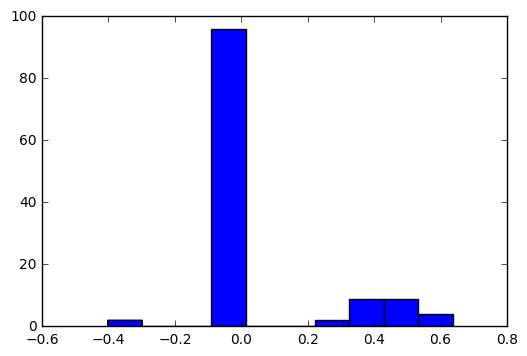

In [45]:
import matplotlib.pyplot as plt
plt.hist(polarity)
plt.show()